In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.executable

'/home/akarshkumar0101/miniconda3/bin/python'

In [4]:
import torch
import numpy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
from transformers import GPT2Model, AutoTokenizer, AutoModelForCausalLM
from memory_gpt2 import *

In [7]:
import datasets

In [8]:
from datasets import load_dataset

dataset = load_dataset("bookcorpus")

Reusing dataset bookcorpus (/home/akarshkumar0101/.cache/huggingface/datasets/bookcorpus/plain_text/1.0.0/44662c4a114441c35200992bea923b170e6f13f2f0beb7c14e43759cec498700)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 74004228
    })
})

In [10]:
dataset.shape

{'train': (74004228, 1)}

In [10]:

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [269]:
np.sum([p.numel() for p in model.parameters()])

124439808

In [271]:
np.sum([p.numel() for p in model.parameters()])

81912576

In [278]:
GPT2Model

transformers.models.gpt2.modeling_gpt2.GPT2Model

In [297]:
class MyGPT2Model(GPT2Model):
    def __init__(self, config):
        super(MyGPT2Model, self).__init__(config)
        
        # ...
        
        self.init_weights()
        
    def forward(self, x):
        pass
        
        
my_model = MyGPT2Model.from_pretrained("distilgpt2")

Some weights of the model checkpoint at distilgpt2 were not used when initializing MyGPT2Model: ['lm_head.weight']
- This IS expected if you are initializing MyGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MyGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [302]:
from torch import nn

In [311]:
a = nn.utils.parameters_to_vector(model.transformer.parameters()).detach()
b = nn.utils.parameters_to_vector(my_model.parameters()).detach()
(a-b).abs().max().item()

0.0

In [293]:
a = dir(model)
b = dir(my_model)
[i for i in a if i not in b], [i for i in b if i not in a]

(['lm_head', 'set_output_embeddings', 'transformer'],
 ['_prune_heads',
  'drop',
  'embed_dim',
  'gradient_checkpointing',
  'h',
  'ln_f',
  'wpe',
  'wte'])

In [296]:
type(model), type(model.transformer)

(transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel,
 transformers.models.gpt2.modeling_gpt2.GPT2Model)

In [53]:
from transformers import GPT2Tokenizer, GPT2Model
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# model = GPT2Model.from_pretrained('gpt2')
text = "Aliens came to earth and "
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [55]:
output.logits.shape

torch.Size([1, 7, 50257])

In [56]:
tokenizer.convert_ids_to_tokens(output.logits[0].argmax(dim=-1))

['ĠThe', '.', 'Ġto', 'Ġthe', 'Ġin', 'Ġthe', 'iced']

In [57]:
tokenizer.decode(output.logits[0].argmax(dim=-1))

' The. to the in theiced'

In [63]:
768*50257

38597376

In [ ]:
np.sum([p.numel() for p in model.parameters()])

81912576

In [ ]:
38597376/81912576

0.4712020776882905

In [255]:
np.sum([p.numel() for p in model.transformer.wpe.parameters()])

786432

In [254]:
1024*768

786432

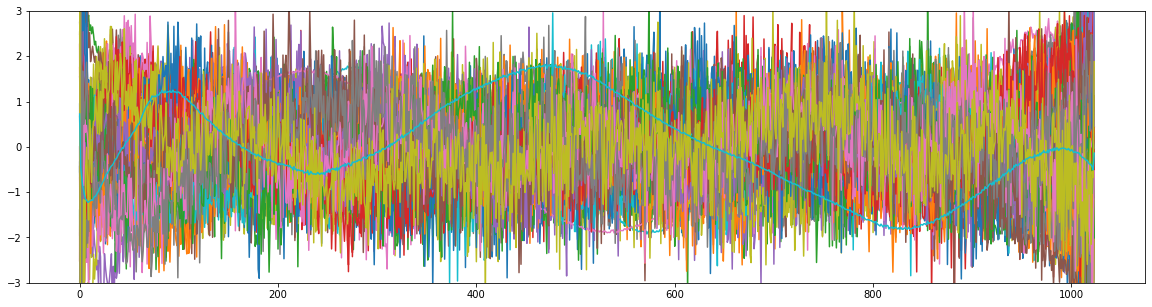

In [252]:
plt.figure(figsize=(20, 5))
for i in range(50):
    a = model.transformer.wpe.weight[:, i].detach().numpy()
    a = (a-a.mean())/a.std()
    plt.plot(a)
plt.ylim(-3, 3)
plt.show()

In [263]:
tokenizer.tokenize("I have a new GPU!")

['I', 'Ġhave', 'Ġa', 'Ġnew', 'ĠGPU', '!']

In [258]:
model.transformer.wte.weight.shape

torch.Size([50257, 768])

In [88]:
input_string = "Yesterday I spent several hours in the library, studying"
input_tokens = tokenizer.encode(input_string, return_tensors = "pt")

output_greedy = model.generate(input_tokens, max_length=100)

output_string = tokenizer.decode(output_greedy[0], \
        skip_special_tokens=True)

print(f"Input sequence: {input_string}")

print(f"Output sequence: {output_string}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input sequence: Yesterday I spent several hours in the library, studying
Output sequence: Yesterday I spent several hours in the library, studying the library and the library. I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to


In [111]:
def generate_default(input_string):
    input_tokens = tokenizer.encode(input_string, return_tensors = "pt")

    output_greedy = model.generate(input_tokens, max_length=100)

    output_string = tokenizer.decode(output_greedy[0], skip_special_tokens=True)
    print(f"Input sequence: {input_string}")
    print(f"Output sequence: {output_string}")
    
def generate_mine(input_string):
    input_tokens = tokenizer.encode(input_string, return_tensors = "pt")

    for i in tqdm(range(100)):
        next_token = model(input_tokens).logits[0,-1].argmax()
        # tokenizer.decode(next_token)
        # print(next_token.shape)
        input_tokens = torch.cat([input_tokens, next_token[None, None]], dim=-1)

    output_string = tokenizer.decode(input_tokens[0], skip_special_tokens=True)
    print(f"Input sequence: {input_string}")
    print(f"Output sequence: {output_string}")
    
    
generate_default("Yesterday I spent several hours in the library, studying")
generate_mine("Yesterday I spent several hours in the library, studying")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input sequence: Yesterday I spent several hours in the library, studying
Output sequence: Yesterday I spent several hours in the library, studying the library and the library. I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to



Input sequence: Yesterday I spent several hours in the library, studying
Output sequence: Yesterday I spent several hours in the library, studying the library and the library. I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about, but I was able to find a few things that I didn't know about


In [149]:
input_string = "Yesterday I spent several hours in the library, studying hello how are you doing my name is akarsh and this is what I am doing right now"
input_tokens = tokenizer.encode(input_string, return_tensors = "pt")

output = model.forward(input_tokens, output_attentions=True)

In [150]:
output.attentions[0].shape

torch.Size([1, 12, 29, 29])

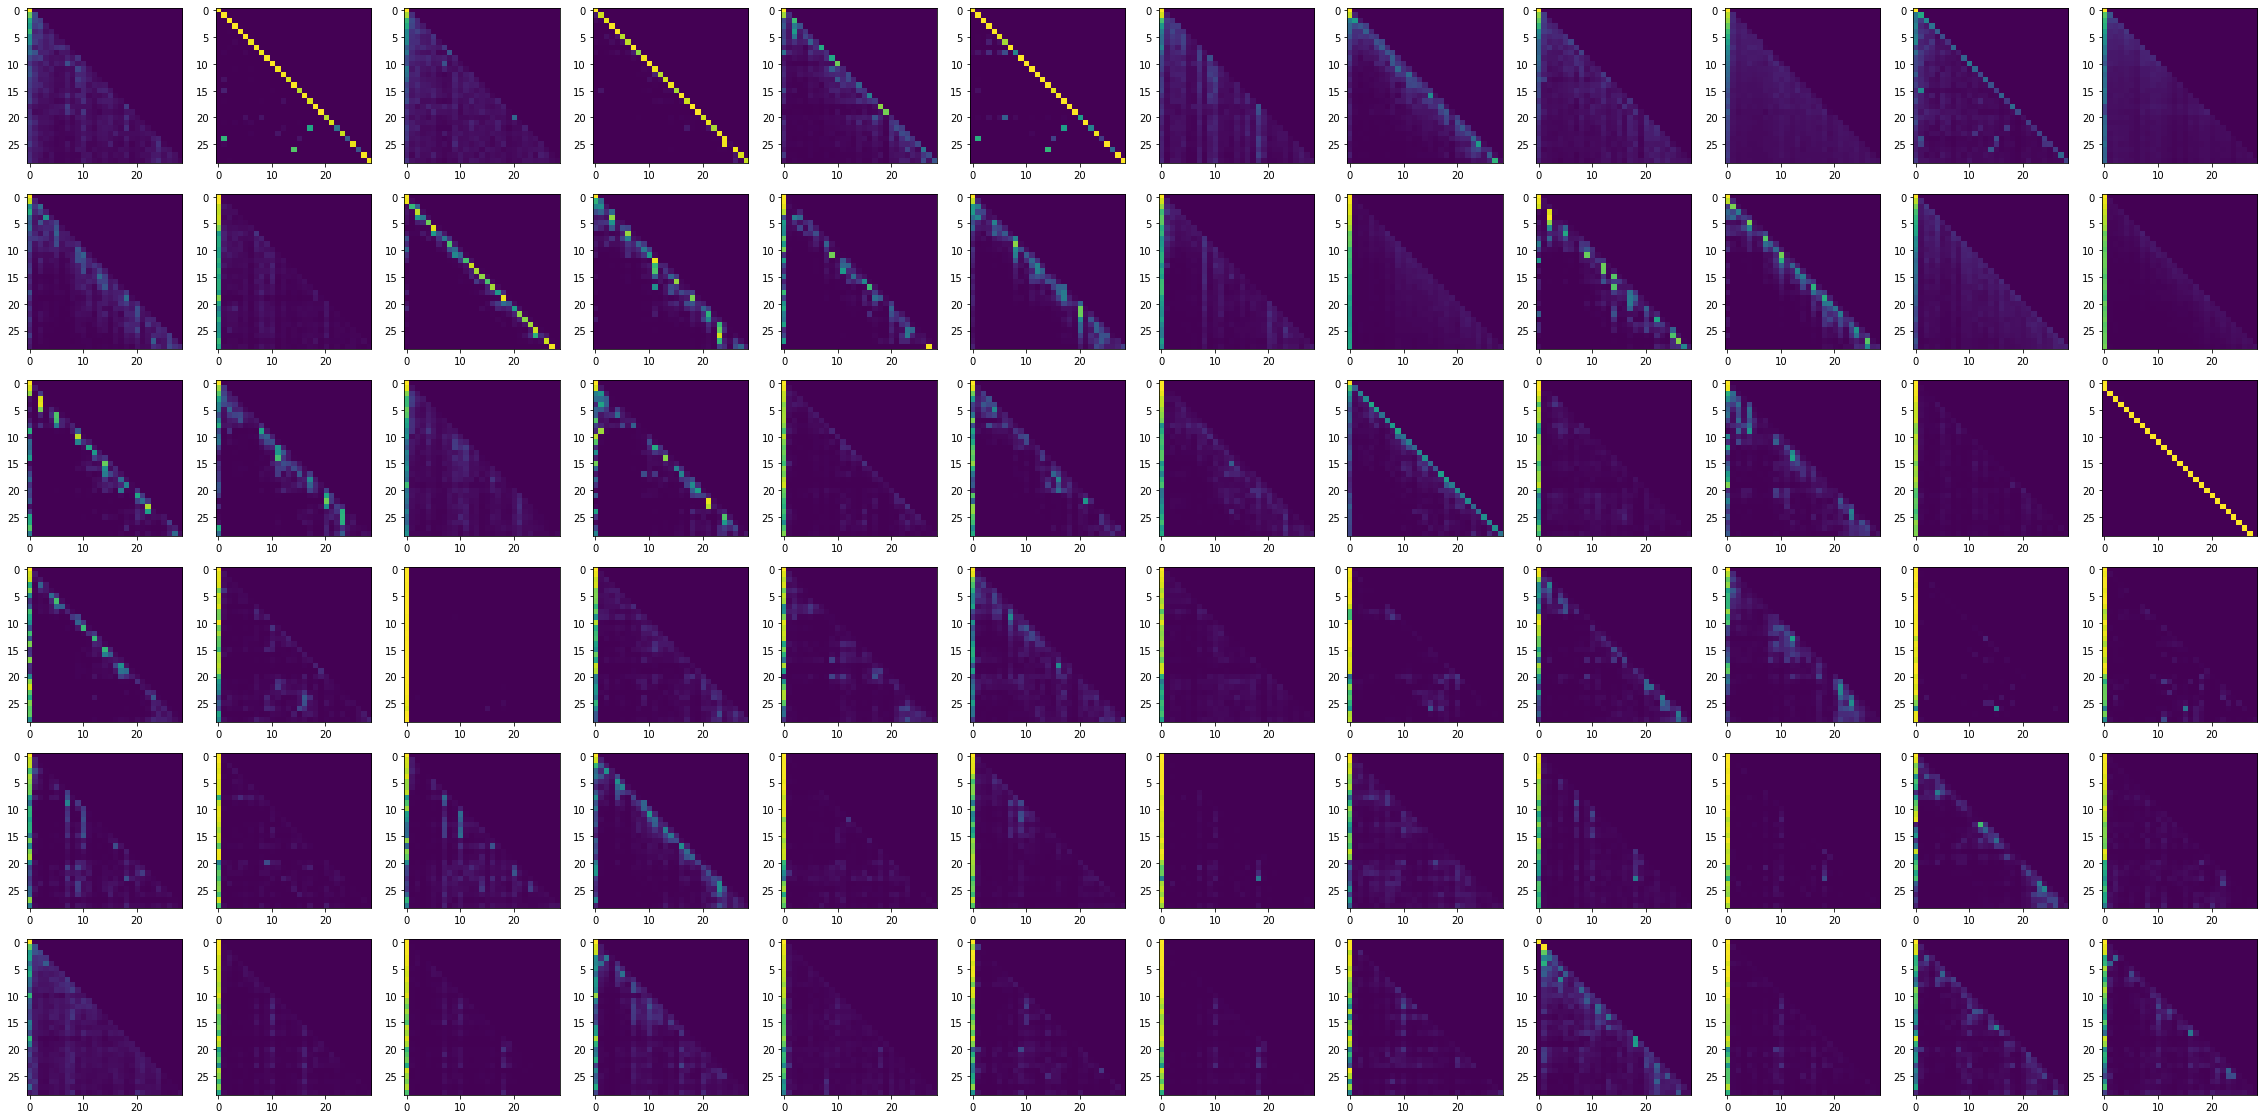

In [218]:
plt.figure(figsize=(40, 20))
i = 1
for a in output.attentions:
    for b in a[0]:
        plt.subplot(len(output.attentions), len(a[0]), i)
        plt.imshow(b.detach().numpy())
        i += 1
        
plt.show()
    
# plt.imshow(output.attentions[0][0, 3].detach().numpy())
# plt.colorbar()

In [194]:
a = model.transformer.wpe.forward(torch.arange(1024))

In [196]:
a.shape

torch.Size([1024, 768])

In [78]:
outputs = model(**model.prepare_inputs_for_generation(encoded_input['input_ids']))

In [85]:
outputs.logits[:, -1, :]

tensor([[-44.8638, -46.6075, -47.9931,  ..., -55.7115, -49.7722, -49.3076]],
       grad_fn=<SliceBackward0>)

In [ ]:
model.post_init